## Welcome to ƒVDB! ##

In this notebook, we hope to acquaint you with the basic concepts, motivations and functionality of the core objects in ƒVDB.  By the end of the first notebook, we will train a basic network which we will take deeper dives into in subsequent notebooks.

### What are *Sparse* Grids?

In ƒVDB, we are fundamentally concerned with **sparse grids**.  What do these words mean?

When we refer to a **grid**, we're referring to a 3-dimensional space divided into uniformly sized voxels where there exists some interesting value in each voxel.  

When we refer to a **sparse** grid, we're referring to a grid where only a subset of the voxels which contain interesting or **active** values exist in the grid.  This is in contrast to a **dense** grid where every voxel in the 3D space is occupied and contains a value (even if the value is 0 or some other null or default value).

Here are some examples of data that can be useful to think of through the lens of sparsity:


<center>
<div class="image-container">
<figure> <img src="img/bunny_volume.jpg"  alt="bunny" width="380"/>  <figcaption>A volumetric cloud in the shape of a bunny</figcaption> </figure> 

<figure>
<video   width="440" height="320" controls loop onloadstart="this.playbackRate = 0.25;">
<source src="img/first-3d-brain-reconstruction-strip.mp4" type="video/mp4">
</video>
<figcaption>A 3D scan of a head</figcaption> 
</figure>
</div>
</center>

<style>
.image-container {
  display: flex;
  gap: 10px; /* Adjust the gap value as needed */
}

figure {
  display: block;
  margin-left: auto;
  margin-right: auto;
  text-align: center;
  width: fit-content;
}

img {
  max-width: 100%;
  height: auto;
}

figcaption {
  margin-top: 10px;
}
</style>


#### Sparse vs. Dense Grids

Why is this a useful distinction?  To start, let's think about images as 2D grids which are easy to visualize.  We can think of an image as a 2D **dense** grid where each pixel/voxel in our grid contains a value such as this representation of a hand-drawn '2':


<center>

<img src="img/two.png"  alt="two" width="200"/>

</center>

In this image, every pixel, or 2D 'voxel' if you will, contains a value but some of these values exist at positions unoccupied by the '2' figure.  If we were to visualize this image as a **sparse** 2D grid where only the pixels containing the '2' figure are **active**, we would have something like this:

<center>

<img src="img/sparse_two.png"  alt="two" width="200"/>

</center>

Effectively we've reduced the amount of data by 58% in this case by only storing the **active** voxels that are of interest to us.  This is the fundamental motivation behind sparse grids: to reduce the amount of data we need to store and process by only storing the **active** voxels we wish to track.

In real-world applications it is often the case that we only have interesting values in a small subset of voxels within the **dense** grid representing a space.  For example, for a LiDAR dataset we may only care about spaces where points exist along the surface of an object where the object is detected by the sensor.  It is not uncommon in these realworld cases that the **sparse** grid would contain less than 10% of the voxels compared to the equivalent **dense** grid for the same data.

### Why ƒVDB?

There is a problem if we naively move our deep learning networks from **dense** to **sparse** grids.  If we think about our image usecase as a stand-in for 2D **dense** grids, our 2D **dense** grids can be expressed as a tensor of dimensions $[C, H, W]$.  

<center>
<img src="img/numbers.png"  alt="two" width="400"/>
</center>

Having a series of images of the same height, width and channel count concatenated together as a single tensor of a batch with dimensions $[N, C, H, W]$ is a well-supported practice for training a network with mini-batches (where $N$ is the number of grids in the batch).  Many operators, like convolution, are effectively accelerated on GPUs for batches of these **dense** volumes since the operators can be very efficiently parallelized over lots of images in this format:


<center>
<div class="image-container">
<figure> <img src="img/imagestack.png"  alt="two" width="200"/>  <figcaption>Mini-batch of 'dense 2D grids'</figcaption> </figure> <figure>   <img src="img/2dconv.png"  alt="two" width="200"/>  <figcaption>Convolution over 'dense 2D grid' minibatch</figcaption> </figure>
</div>
</center>

<style>
.image-container {
  display: flex;
  gap: 10px; /* Adjust the gap value as needed */
}

figure {
  display: block;
  margin-left: auto;
  margin-right: auto;
  text-align: center;
  width: fit-content;
}

img {
  max-width: 100%;
  height: auto;
}

figcaption {
  margin-top: 10px;
}
</style>

With **sparse** grids, it is very unlikely we'll have multiple grids with the same topology of **active** voxels and therefore the same number of voxels in grids that we could batch together to use these same operators.  It won't be as simple as cropping or scaling an image to fit a fixed size to create a $[N, C, H, W]$ tensor for sparse grids that have different topologies like these:

<center>
<img src="img/blank_sparse_grids.png"  alt="two" width="600"/>
</center>

This is the fundamental problem that **ƒVDB** is designed to solve using novel data structures that marry technologies from [OpenVDB](https://www.openvdb.org/) and [PyTorch](https://pytorch.org/).

### Training a Simple Network

To get going and show how easy it is to start working with sparse grids in ƒVDB, let's train a simple network to classify the voxels in a grid as being inside or outside of a sphere using fVDB and all the standard PyTorch functionality.

&#x1F4A1;  We will cover all the details of what is happening in the code below in subsequent notebooks.  For now, just run the code and see the results!

In [2]:
import numpy as np
import tqdm
import torch

import fvdb
from fvdb.nn import LeakyReLU, Sigmoid, Linear, VDBTensor

# RandomGridsDataset produces a batch of sparse grids with a random number of randomly activated voxels in it
class RandomGridsDataset(torch.utils.data.Dataset):
    def __init__(self, batch_size):
        self.batch_size = batch_size
    def __len__(self):
        return 100
    def __getitem__(self, idx) -> VDBTensor:
        # create a random number of voxels in each grid with random voxel indexes (ijk's) between -200, 200 in each dimension
        ijks = [torch.randint(-200, 200, (np.random.randint(5_000, 50_000), 3), device='cuda') for i in range(self.batch_size)]
        # make a batch of sparse grids from the ijk's!
        sparse_gridbatch = fvdb.sparse_grid_from_ijk(fvdb.JaggedTensor(ijks), voxel_sizes=0.005)
        # features are just the world-space coordinates of each voxel
        features = sparse_gridbatch.grid_to_world(sparse_gridbatch.ijk.float())
        # produce a 'VDBTensor' which is a convenience for holding the sparse grid and its features
        return VDBTensor(sparse_gridbatch, features)

# Define a basic MLP-type model from ƒVDB modules
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc0 = Linear(3, 16)
        self.fc1 = Linear(3, 16)
        self.fc2 = Linear(32, 32)
        self.fc3 = Linear(32, 1)
        self.relu = LeakyReLU()
        self.sigmoid = Sigmoid()
    def forward(self, x):
        # concatenate the features produced by two different linear layers
        x = self.relu(VDBTensor.cat([self.fc0(x), self.fc1(x)], dim=1))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


# Data
batch_size = 8
dataset = RandomGridsDataset(batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=lambda x: x[0])

# Model, Loss, Optimizer
model = Model().to('cuda')
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

# Simple training loop for 10 epochs
epochs = 10
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(data)
            # whether each voxel is inside or outside of the unit sphere centered at the origin of the grid space
            dist = torch.sqrt(torch.sum(data.grid.grid_to_world(data.grid.ijk.float()).jdata ** 2, dim=1))
            target = (dist < 1).float()
            l = loss(output.feature.jdata, target[:, None])
            l.backward()
            optimizer.step()
            pbar.set_description(f"Epoch {epoch}, batch {i}, loss {l.item()}")
        pbar.update(1)


Epoch 9, batch 99, loss 0.03371221199631691: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Let's visualize a sample of predictions from the network to see how well we're doing!

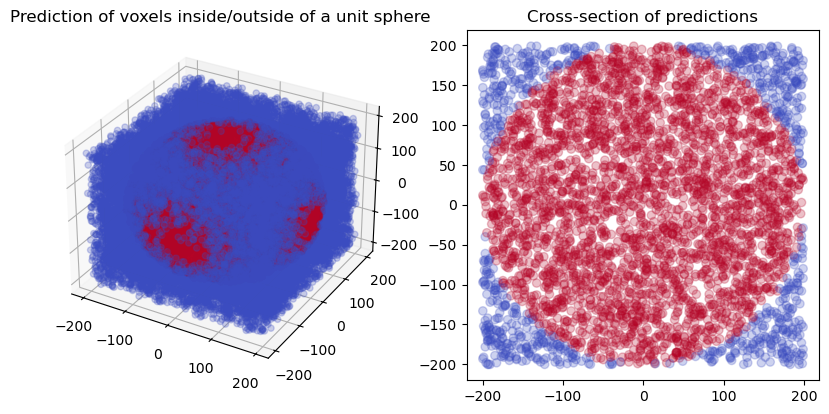

In [3]:
import matplotlib.pyplot as plt

test_data = next(iter(dataloader))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2,2,1, projection='3d')

# get predictions from the trained model
model.eval()
pred = model(test_data)

ijks_0 = pred.grid.ijk.jdata[pred.grid.jidx==0].detach().cpu().numpy()
pred_0 = pred.feature.jdata[pred.feature.jidx==0].detach().cpu()

preds_in_sphere = ijks_0[torch.round(pred_0)[:,-1] == 1]

ax.scatter3D(ijks_0[:, 0], ijks_0[:, 1], ijks_0[:, 2], marker = 'o', c = torch.round(pred_0), cmap='coolwarm', alpha =0.25)
ax.set_title("Prediction of voxels inside/outside of a unit sphere")

# Also plot a 2D slice to make it easier to see
pred_0 = pred_0[((ijks_0[:, 2]>-20) & (ijks_0[:, 2]<20))]

ijks_0 = ijks_0[((ijks_0[:, 2]>-20) & (ijks_0[:, 2]<20))]

ax = fig.add_subplot(2,2,2)
ax.scatter(ijks_0[:, 0], ijks_0[:, 1], c=torch.round(pred_0), marker = 'o', cmap='coolwarm', alpha=0.25)
ax.set_title("Cross-section of predictions")

fig.show()
